In [1]:
from __future__ import print_function
import time
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, BatchNormalization,GRU
from keras.datasets import imdb

import os
from keras.preprocessing.text import Tokenizer

Using Theano backend.


In [2]:

X_train = []
y_train = []

path = 'C:/1_Research/Create_data/aclImdb/train/pos/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([1 for _ in range(135526)])

path = 'C:/1_Research/Create_data/aclImdb/train/neg/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([0 for _ in range(100972)])

In [3]:

X_test = []
y_test = []

path = 'C:/1_Research/Create_data/aclImdb/test/pos/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([1 for _ in range(135526)])

path = 'C:/1_Research/Create_data/aclImdb/test/neg/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([0 for _ in range(100972)])

In [4]:
print("Number of words: ")
print(len(np.unique(np.hstack(X_train ))))

Number of words: 
232229


Review length: 
Mean 1169.90 words (884.047034)


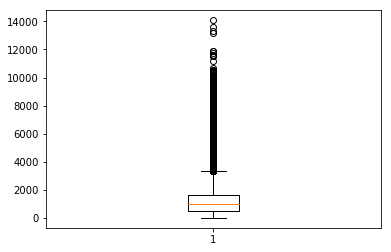

In [5]:
from matplotlib import pyplot
# Summarize review length
print("Review length: ")
result = map(len, X_train)
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

In [6]:

max_features =5000
max_len = 100  # cut texts after this number of words (among top max_features most common words)

In [7]:

#tokenize works to list of integers where each integer is a key to a word
imdbTokenizer = Tokenizer(nb_words=max_features)

imdbTokenizer.fit_on_texts(X_train)

In [8]:
#create int to word dictionary
intToWord = {}
for word, value in imdbTokenizer.word_index.items():
    intToWord[value] = word

#add a symbol for null placeholder
intToWord[0] = "!!!NA!!!"
    
#print(intToWord[1])
#print(intToWord[2])
#print(intToWord[32])

In [9]:
#convert word strings to integer sequence lists
#print(X_train[0])
#print(imdbTokenizer.texts_to_sequences(X_train[:1]))
#for value in imdbTokenizer.texts_to_sequences(X_train[:1])[0]:
    #print(intToWord[value])
    
X_train = imdbTokenizer.texts_to_sequences(X_train)
X_test = imdbTokenizer.texts_to_sequences(X_test)

In [10]:

# Censor the data by having a max review length (in number of words)

#use this function to load data from keras pickle instead of munging as shown above
#(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features,
#                                                      test_split=0.2)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

236498 train sequences
236498 test sequences
Pad sequences (samples x time)
X_train shape: (236498L, 100L)
X_test shape: (236498L, 100L)


In [11]:
epochs = 2
embedding_neurons = 64
lstm_neurons = 128
batch_size =32

In [12]:

# Forward Pass LSTM Network

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)

# dropout 
after_dp = Dropout(0.5)(forwards)
output = Dense(1, activation='sigmoid')(after_dp)

model_fdir_atom = Model(input=sequence, output=output)
# review model structure
print(model_fdir_atom.summary())



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 100, 64)       320000      input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 100, 64)       256         embedding_1[0][0]                
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           74112       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [ ]:
# Forward pass LSTM network

# try using different optimizers and different optimizer configs
model_fdir_atom.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
print('Train...')
start_time = time.time()

history_fdir_atom = model_fdir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

scores = model_fdir_atom.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train...
Train on 236498 samples, validate on 236498 samples
Epoch 1/2


In [ ]:

# Bi-directional Atom

# based on keras tutorial: https://github.com/fchollet/keras/blob/master/examples/imdb_bidirectional_lstm.py

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_atom = Model(input=sequence, output=output)
# review model structure
print(model_bidir_atom.summary())

In [ ]:
model_bidir_atom.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy','precision', 'recall', 'fmeasure'])

print('Train...')
start_time = time.time()

history_bidir_atom = model_bidir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)
scores = model_fdir_atom.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))